In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from implementations import *
from helpers import *
from Model import *

In [39]:
[yb_t, input_data_t, ids_t, yb_test, input_data_test, ids_test] = pickle.load(open( "dat.p", "rb" ))
input_clean = clean_data(input_data_t)
test_clean = clean_data(input_data_test)

In [40]:
def replaceByMeanPerFeature(input_tx_train, input_y_train, input_tx_test, input_y_test):
    train_mean = np.nanmean(input_tx_train, axis=0) # Computes the mean per column without considering nan value
    for ind, mean in enumerate(train_mean):
        mask_tmp = np.isnan(input_tx_train[:,ind])
        input_tx_train[mask_tmp, ind] = mean
        mask_tmp = np.isnan(input_tx_test[:,ind])
        input_tx_test[mask_tmp, ind] = mean
    y_train = input_y_train
    y_test = input_y_test
    return input_tx_train, y_train, input_tx_test, y_test


In [41]:
input_tx_train, y_train, input_tx_test, y_test = replaceByMeanPerFeature(input_clean, yb_t, test_clean, yb_test)


In [42]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly[:, 1:]

def augment_feat(input_tx_train, input_tx_test, degree):
    n_features = len(input_tx_train[0])
    for ind in range(1, n_features):
        input_tx_train = np.c_[input_tx_train, build_poly(input_tx_train[:, ind], degree)]
        input_tx_test = np.c_[input_tx_test, build_poly(input_tx_test[:, ind], degree)]
    return input_tx_train, input_tx_test

def augment_feat_no_test(input_tx_train, degree):
    n_features = len(input_tx_train[0])
    for ind in range(1, n_features):
        input_tx_train = np.c_[input_tx_train, build_poly(input_tx_train[:, ind], degree)]
    return input_tx_train



In [96]:
%%time
from cross_val import *

#SGD.fit(y_train, tx_std)
lambdas = np.logspace(-5, 3, 10)
polys = [1,2,3]
results = {}
for lambda_ in lambdas:
    for poly in polys:
        input_tx_train_pol = augment_feat_no_test(input_tx_train, poly)
        tx_std, mean_x, std_x = standardize(input_tx_train_pol)
        mod = ridge_regression(lambda_)
        loss_tr, loss_te = cross_validation(mod,y_train,tx_std, 5)
        results[(lambda_,poly)] = [np.mean(loss_tr),np.mean(loss_te)]


Wall time: 3min 26s


In [101]:
results

{(1.0000000000000001e-05, 1): [1.7020086240404472e-06, 6.8098810961785722e-06],
 (1.0000000000000001e-05, 2): [1.6179136222371208e-06, 7.6762463021471168e-06],
 (1.0000000000000001e-05, 3): [1.8797998650812013e-06, 9.8489093334474093e-06],
 (7.7426368268112782e-05, 1): [1.7020086244964167e-06, 6.8098810891704706e-06],
 (7.7426368268112782e-05, 2): [1.6420878924098374e-06, 7.9698863967679284e-06],
 (7.7426368268112782e-05, 3): [1.9011499371405919e-06, 1.5142194715616689e-05],
 (0.00059948425031894088, 1): [1.702008651761534e-06, 6.8098811299105421e-06],
 (0.00059948425031894088, 2): [1.6883558204705868e-06, 8.5149464417336294e-06],
 (0.00059948425031894088, 3): [1.9951016068420692e-06, 1.0990933496121401e-05],
 (0.0046415888336127772, 1): [1.7020102544603255e-06, 6.8098870153062818e-06],
 (0.0046415888336127772, 2): [1.7298846122932464e-06, 8.618337959009681e-06],
 (0.0046415888336127772, 3): [2.0885203832540082e-06, 9.031415589732006e-06],
 (0.035938136638046257, 1): [1.702093313280558

In [102]:
np.min([results[key][1] for key in results])

6.8098810891704706e-06

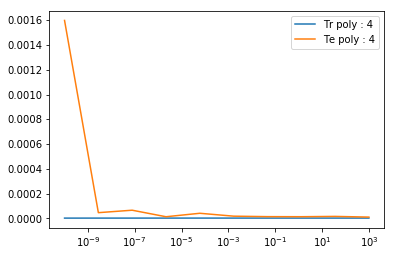

In [74]:
%matplotlib inline
plt.figure()
for i in [4]:
    plt.semilogx(results[:,0,0], results[:,i-1,1], label = 'Tr poly : '+str(i))
    plt.semilogx(results[:,0,0], results[:,i-1,2], label ='Te poly : '+str(i))
plt.legend()    
plt.show()

In [108]:
%%time
input_tx_train_pol = augment_feat_no_test(input_tx_train, 1)
tx_std, mean_x, std_x = standardize(input_tx_train_pol)

Wall time: 3.9 s


In [109]:
%%time
ridge = ridge_regression(7.7426368268112782e-05)
ridge.fit(y_train, tx_std)

Wall time: 212 ms


In [111]:
%%time
input_tx_te_pol = augment_feat_no_test(input_tx_test, 1)
tx_te_std = (input_tx_te_pol-mean_x)/mean_x

Wall time: 8.99 s


In [112]:
y_pred_test = ridge.predict(input_tx_te_pol)

In [113]:
y_pred_bin = np.array([-1 if p<0 else 1 for p in y_pred_test])
np.sum(y_pred_bin)

545190

In [114]:
create_csv_submission(ids_test, y_pred_bin, 'sub3.csv')

In [106]:
input_tx_train_pol.shape

(250000, 59)